<a href="https://colab.research.google.com/github/Daniblue25/My-medical-work/blob/main/Classification_de_la_tuberculose_et_pneumonie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tqdm import tqdm

In [ ]:
# Pour le importation et le traitement
import pandas as pd
import numpy as np
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn
from sklearn.utils import shuffle

# Pour la conception du modèle de classification
import tensorflow
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

## Importation des données

In [ ]:
from itertools import repeat
image_directory = '/content/drive/MyDrive/Image médicale/Big data/'

def read_images(images_path, label="Normal"):
  size = 224
  dataset = []
  labels = []
  Normal_images = os.listdir(image_directory + label)
  for i, image_name in enumerate(Normal_images):    
    image = cv2.imread(image_directory + label + "/" + image_name)
    image = Image.fromarray(image)
    image = image.resize((size,size))
    dataset.append(np.array(image))
  return dataset, list(repeat(label, len(dataset)))

  
dataset_names =["Normal", "Pneumonie", "Tuberculose"]
all_images, all_labels =[],[]
for dataset_name in dataset_names:
  image , label = read_images(image_directory, label=dataset_name)
  all_images.append(image)
  all_labels.append(label)

In [ ]:
len(all_labels[0])

1281

In [ ]:
labels_all= np.hstack(all_labels)
images_all= np.vstack(all_images)

In [ ]:
labels_all

array(['Normal', 'Normal', 'Normal', ..., 'Tuberculose', 'Tuberculose',
       'Tuberculose'], dtype='<U11')

In [ ]:
print("Nombre totale d'images =", len(dataset))

Nombre totale d'images = 2132


In [ ]:
type(dataset[0])

numpy.ndarray

In [ ]:
images, labels = shuffle(images_all, labels_all, random_state=10)

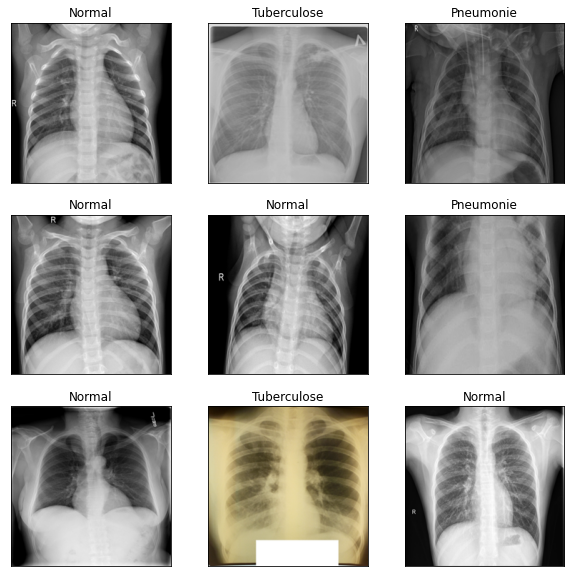

In [ ]:
classe = ["Normal", "Pneumonie", "Tuberculose"]
fig = plt.figure(figsize=(10,10))

for idx in np.arange(9):
    ax = fig.add_subplot(3,3, idx + 1, xticks = [], yticks = [])
    plt.imshow(images[idx])
    ax.set_title("{}".format(labels[idx]))

In [ ]:
from collections import Counter
Counter(labels)

Counter({'Normal': 1281, 'Tuberculose': 700, 'Pneumonie': 718})

## Preparation pour l'entrainement


In [ ]:
X_train[0]

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5)

## Normalisation 

In [ ]:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [ ]:
print("Number of training examples: {}".format(len(X_train)))
print("Number of validation examples: {}".format(len(X_val)))
print("Number of testing examples: {}".format(len(X_test)))

Number of training examples: 2159
Number of validation examples: 270
Number of testing examples: 270


In [ ]:
print("X_train : ", X_train.shape)
print("y_train : ", y_train.shape)
print("X_val : ", X_val.shape)
print("y_val : ", y_val.shape)
print("X_test : ", X_test.shape)
print("y_test : ", y_test.shape)


X_train :  (2159, 224, 224, 3)
y_train :  (2159,)
X_val :  (270, 224, 224, 3)
y_val :  (270,)
X_test :  (270, 224, 224, 3)
y_test :  (270,)


In [ ]:
train_gen = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet_v2.preprocess_input)

In [ ]:
train_gen.fit(X_train)
#train_gen.fit(X_val)

## Construction du model

**Appel du modèle pré_entrainé**

 MobileNetV2

In [ ]:
pre_model = keras.applications.MobileNetV2( input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='avg')

pre_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
inputs = pre_model.input

x = keras.layers.Dense(512, activation='relu')(pre_model.output)
x = keras.layers.Dense(64, activation = 'relu')(x)
outputs = keras.layers.Dense(3, activation ='softmax')(x)
print(outputs.shape)
model_0 = keras.Model(inputs=inputs, outputs=outputs)

model_0.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']
)

(None, 3)


In [ ]:
to_categorical(y_test, 3)

In [ ]:
y_train

array(['Normal', 'Pneumonie', 'Normal', ..., 'Pneumonie', 'Normal',
       'Tuberculose'], dtype='<U11')

In [ ]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)
y_val = encoder.fit_transform(y_val)
print(y_train.shape, y_test.shape, y_val.shape)

(2159, 3) (270, 3) (270, 3)


In [ ]:
y_train

array(['Normal', 'Pneumonie', 'Normal', ..., 'Pneumonie', 'Normal',
       'Tuberculose'], dtype='<U11')

**Application de la transformation sur les données d'entrainement**

In [ ]:
dir_save_model = "/content/drive/MyDrive/Image médicale"
model_name = "MobileNetV2_model.hdf5"
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
checkpoint = ModelCheckpoint(os.path.join(dir_save_model, model_name), monitor='val_accuracy', 
verbose=0, save_best_only=True, mode='max')

In [ ]:
y_train

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [ ]:
y_val.shape, y_train.shape

((270, 3), (2159, 3))

In [ ]:
X_train.shape, X_val.shape

((2159, 224, 224, 3), (270, 224, 224, 3))

In [ ]:
y_val

In [ ]:
history_0 = model_0.fit(X_train, y_train, 
                        validation_data = (X_val, y_val),
                        batch_size = 16, epochs = 20)#, callbacks = [early_stopping,checkpoint])

Epoch 1/20
135/135 [==============================] - 146s 1s/step - loss: 0.2024 - accuracy: 0.9264 - val_loss: 0.1652 - val_accuracy: 0.9333
Epoch 2/20
135/135 [==============================] - 57s 425ms/step - loss: 0.0820 - accuracy: 0.9708 - val_loss: 0.1104 - val_accuracy: 0.9704
Epoch 3/20
135/135 [==============================] - 56s 418ms/step - loss: 0.0713 - accuracy: 0.9736 - val_loss: 0.0937 - val_accuracy: 0.9778
Epoch 4/20
135/135 [==============================] - 56s 412ms/step - loss: 0.0392 - accuracy: 0.9875 - val_loss: 0.1676 - val_accuracy: 0.9630
Epoch 5/20
135/135 [==============================] - 57s 426ms/step - loss: 0.0499 - accuracy: 0.9801 - val_loss: 0.1504 - val_accuracy: 0.9519
Epoch 6/20
135/135 [==============================] - 57s 425ms/step - loss: 0.0311 - accuracy: 0.9889 - val_loss: 0.2332 - val_accuracy: 0.9407
Epoch 7/20
135/135 [==============================] - 55s 408ms/step - loss: 0.0330 - accuracy: 0.9847 - val_loss: 0.0893 - val_accu

In [ ]:
y_val.shape

(270, 3)

In [ ]:
y_val

## Representation graphique

In [ ]:
def plot_accuracy_loss(history, epochs):
    epochs = [i for i in range(epochs)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(15,10)
    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")
    

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    #ax[0].plot(max(history.history["val_loss"]), min(history.history["val_loss"]), marker="o", color="b", label="best model")
    plt.show()

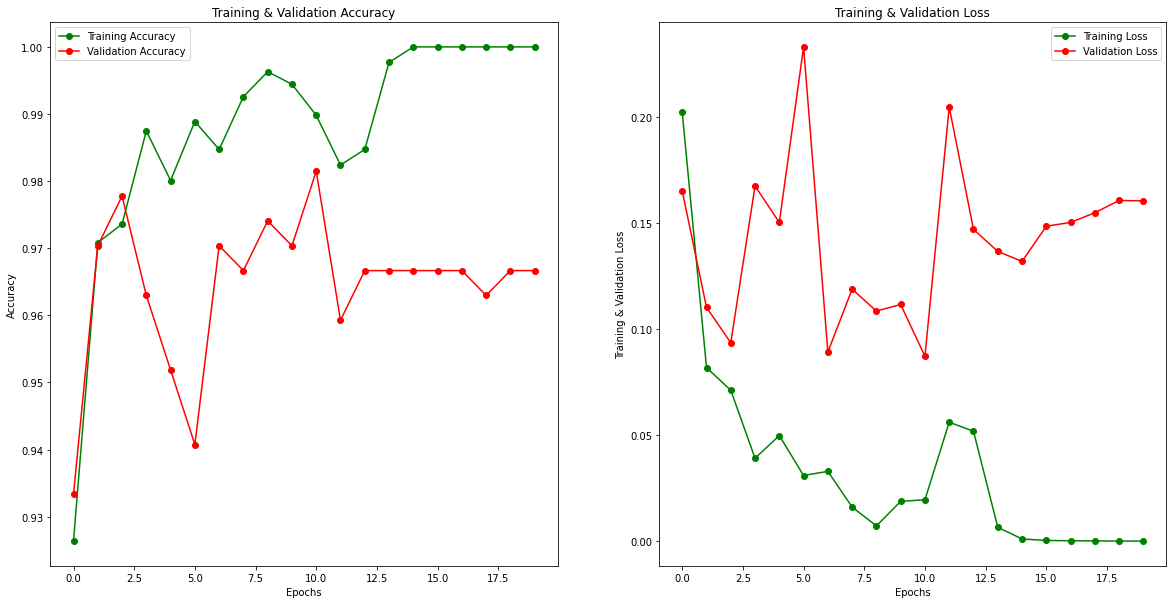

In [ ]:
plot_accuracy_loss(history_0, epochs=20)

## Evaluation du modèle

In [ ]:
# Evaluation du modèle
(eval_loss, eval_accuracy) = model_0.evaluate(X_train, y_train)
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss))

68/68 [==============================] - 46s 673ms/step - loss: 1.1316e-04 - accuracy: 1.0000
[INFO] accuracy: 100.00%
[INFO] Loss: 0.00011315975280012935


In [ ]:
(eval_loss, eval_accuracy) = model_0.evaluate(X_test, y_test)
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss))

## Matrice de confusion et indice de classification

In [ ]:
def confumatix(model, X_test, y_test, classe):           
    mythreshold = 0.5
    from sklearn.metrics import confusion_matrix
    y_pred = (model.predict(np.asarray(X_test)) >= mythreshold).astype(int)
    cm = confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1))       

    import seaborn as sns      
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix '); 
    ax.xaxis.set_ticklabels(classe); ax.yaxis.set_ticklabels(classe)
    from sklearn.metrics import classification_report
    
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=classe))

9/9 [==============================] - 11s 1s/step
              precision    recall  f1-score   support

      Normal       0.97      0.94      0.95       120
   Pneumonie       0.94      0.97      0.95        76
 Tuberculose       0.97      0.97      0.97        74

    accuracy                           0.96       270
   macro avg       0.96      0.96      0.96       270
weighted avg       0.96      0.96      0.96       270



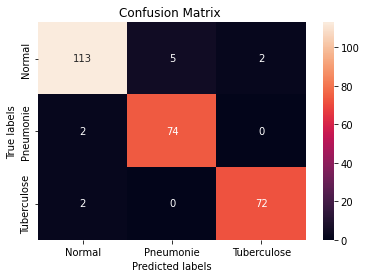

In [ ]:
confumatix(model_0, X_test, y_test, classe)

In [ ]:
classe = ["Normal", "Pneumonie", "Tuberculose"]
fig = plt.figure(figsize=(10,10))
mythreshold = 0.5
preds = (model_0.predict(np.asarray(X_test)) >= mythreshold).astype(int)

for idx in np.arange(9):
    ax = fig.add_subplot(3,3, idx + 1, xticks = [], yticks = [])
    test = (np.array(X_test)).astype(int)
    plt.imshow(test[idx])
    ax.set_title("{} ({})".format(str(classe[preds[idx]]), str(classe[labels[idx]])), color = ("green" if preds[idx]==labels[idx] else "red"))
    #ax
    #ax.set_title("{} ({})".format(preds[idx], y_test[idx]), color = ("green" if preds[idx]==y_test[idx] else "red"))